# Практическое задание

 Почему пользователи на заканчивают курс до конца?
 Как предсказать, что пользователь бросит наш курс?
 Какими основными паттернами поведения взаимодействия с контентом обладают пользователи, которые успешно 
 заканчивают курсы по сравнению с теми, кто эти курсы бросает?
 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Данные 

In [2]:
event_data = pd.read_csv('data/event_data_train.csv')
event_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [3]:
event_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

Преобразуем данные для лучшей читабельности.
1. Переведем timestamp в нормальную дату.

In [4]:
event_data['date'] = pd.to_datetime(event_data.timestamp, unit='s')
event_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [5]:
event_data.date.min()

Timestamp('2015-06-15 04:00:48')

2. Добавим колонку - день выполнения степа

In [6]:
event_data['day'] = event_data.date.dt.date
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Посчитаем, сколько людей заходило на степик каждый день

In [7]:
event_data.groupby('day').user_id.nunique().head()

day
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
Name: user_id, dtype: int64

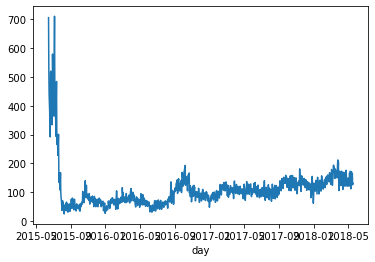

In [8]:
event_data.groupby('day').user_id.nunique().plot()

Посмотрим распределение пользователей по количеству набранных баллов

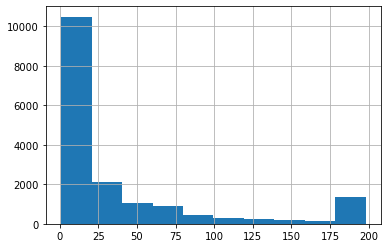

In [9]:
event_data[event_data.action == 'passed'].groupby('user_id', as_index=False).agg({'step_id': 'count'})\
    .rename(columns={'step_id': 'passed_step'}).passed_step.hist()

Мы потеряли пользователей, которые не решили ни одного степа.
Попробуем другой метод.

In [10]:
event_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0)\
    .reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


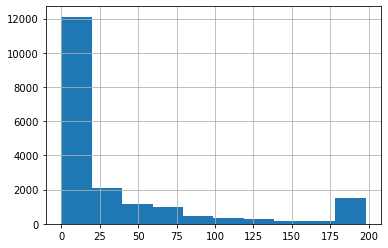

In [11]:
event_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0)\
    .reset_index().discovered.hist()

Посмотрим на второй массив данных

In [12]:
submission_data = pd.read_csv('data/submissions_data_train.csv')
submission_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


Преобразуем даты

In [13]:
submission_data['date'] = pd.to_datetime(submission_data.timestamp, unit='s')
submission_data['day'] = submission_data.date.dt.date
submission_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


Рассчитаем количество пользователей с правильными ответами

In [14]:
user_score = submission_data.pivot_table(index='user_id', 
                                         columns='submission_status',
                                         values='step_id',
                                         aggfunc='count',
                                         fill_value=0).reset_index()
user_score.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Рассчитаем для каждого пользователя, какие у него были перерывы между заходами на курс.
Посмотрим на картину в целом - по всем пользователям.
И примем решение, какое отсутствие мы примем за за тот промежуток, после которого ясно, что пользователь не вернется.

Для исследования оставим только минимум данных без повторений.

In [15]:
gap_data = event_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values
gap_data = pd.Series(np.concatenate(gap_data, axis = 0)) 
gap_data = gap_data / (24 * 60 * 60)

Получилась разница в днях между заходами на курс
Посмотрим на график.

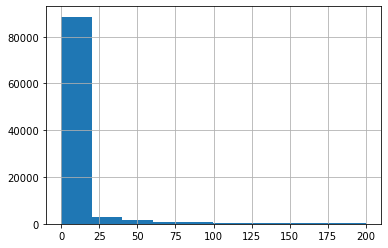

In [16]:
gap_data[gap_data < 200].hist()

In [17]:
gap_data.quantile(0.95)

59.760440972222156

Это значит, что только 5% пользователей возвращаются на курс после 2 месяцев.
Мы возьмем 30 дней, как период отсутствия на курсе для того, чтобы пользователь не вернулся.

## ЗАДАЧА

Введите id Анатолия Карпова, под которым он фигурирует в данных events_data_train и submissions_data_train

In [18]:
user_visit = event_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0)\
    .reset_index()

user_visit.head()

m = user_visit.started_attempt.max()
user_visit.query('started_attempt == @m')

action,user_id,discovered,passed,started_attempt,viewed
781,1046,128,124,721,8122


Разметим наших пользователей по признаку того, являются ли они дропнувшимися или нет.

Если пользователь не получил сертификат и при этом более, чем 30 дней отсутствует на платформе, 
будем считать, что он покинул курс.

In [19]:
event_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


Очевидно, что 2018-05-19 - последняя дата, дата выгрузки данных.

Рассчитаем для каждого пользователя его максимальное время появления на курсе. 

In [20]:
user_data = event_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})
user_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


Узнаем, сколько времени прошло с момента последнего посещения на 2018-05-19 

In [21]:
now = 1526772811
user_data['is_gone_user'] = now - user_data.last_timestamp
user_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,53945347
1,2,1519226966,7545845
2,3,1444581588,82191223
3,5,1499859939,26912872
4,7,1521634660,5138151


Так мы видим период отсутствия каждого пользователя. Теперь посчитаем больше или меньше этот период нашего заданного эталона.

In [22]:
drop_out_threshold = 30 * 24 * 60 * 60
user_data['is_gone_user'] = (now - user_data.last_timestamp) > drop_out_threshold
user_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


Теперь мы выясним, кто из этих пользователей уже закончил курс.

Для начала добавим данные про количество правильных и неправильных ответов.

In [23]:
user_data.merge(user_score).head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,2,1519226966,True,2,0
1,3,1444581588,True,29,23
2,5,1499859939,True,2,2
3,8,1481466913,True,9,21
4,14,1436368676,True,0,1


Таким образом мы потеряли пользователей, которые вообще не решали задачи.

In [24]:
user_data = user_data.merge(user_score, how='left').fillna(0)
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


Сохраним события для пользователей в отдельную таблицу

In [25]:
user_event_data = event_data.pivot_table(index='user_id', 
                                         columns='action',
                                         values='step_id',
                                         aggfunc='count',
                                         fill_value=0).reset_index()
user_event_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Присоединим эти данные к нашей таблице

In [26]:
user_data = user_data.merge(user_event_data, how='left')
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


Добавим информацияю о том, сколько уникальных дней пользователь был в сервисе.

In [27]:
user_day = event_data.groupby('user_id').day.nunique().to_frame().reset_index()
user_day.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [28]:
user_data = user_data.merge(user_day, how='left')
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


Добавим колонку признака окончания курса. Тех, кто набрал больше 170 пройденных шагов.

In [29]:
user_data['passed_course'] = user_data.passed > 170
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [30]:
user_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


Попробуем предсказать по поведению пользователя на курсе в первые n дней, уйдет он с курса или нет.

Для начала возьмем 3 дня. 

Вообще просто пока посмотрим на медиану кол-ва дней для пользователей, которые прошли курс.

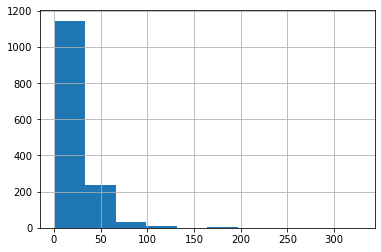

In [31]:
user_data[user_data.passed_course].day.hist()

In [32]:
user_data[user_data.passed_course].day.median()

20.0

Соберем события, которые происходили с пользователей в первые 3 дня из общего датафрейма.

In [33]:
user_min_time = event_data.groupby('user_id', as_index=False).agg({'timestamp': 'min'}).rename({'timestamp': 'min_timestamp'}, axis=1)
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


Присоединим эти данные к нашему датасету

In [34]:
user_data = user_data.merge(user_min_time, how='left')
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


Теперь надо отобрать те записи, которые попадают в три дня

In [35]:
event_data['user_time'] = event_data.user_id.map(str) + '_' + event_data.timestamp.map(str)
event_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [36]:
learning_time_threshold = 3 * 24 * 60 * 60
learning_time_threshold

259200

In [37]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [38]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold
user_min_time.head()

,user_id,min_timestamp,user_learning_time_threshold
0,1,1472827464,1_1473086664
1,2,1514383364,2_1514642564
2,3,1434358476,3_1434617676
3,5,1466156809,5_1466416009
4,7,1521634660,7_1521893860


In [39]:
event_data = event_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='left')
event_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [40]:
event_data_train = event_data[event_data.user_time <= event_data.user_learning_time_threshold]
event_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


Убедимся, что данные норм

In [41]:
event_data_train.groupby('user_id').day.nunique().max()


4

Сделаем то же самое с submissions

In [42]:
submission_data['users_time'] = submission_data.user_id.map(str) + '_' + submission_data.timestamp.map(str)
submission_data = submission_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submission_data_train = submission_data[submission_data.users_time <= submission_data.user_learning_time_threshold]
submission_data_train.groupby('user_id').day.nunique().max()

4

Соберем данные и попробуем обучить базовую модель

In [43]:
X = submission_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day': 'day_count'})
X.head()

,user_id,day_count
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


Найдем количество степов, которые пользователь попытался решить за первые три дня

In [44]:
step_tried = submission_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={'step_id': 'step_count'})
step_tried.head()

,user_id,step_count
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


Добавим в исходные данные

In [45]:
X = X.merge(step_tried, on='user_id', how='left')
X.head()

,user_id,day_count,step_count
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23


Добавим данные по сабмитам

In [46]:
X = X.merge(submission_data_train.pivot_table(index='user_id', 
                                              columns='submission_status',
                                              values='step_id',
                                              aggfunc='count',
                                              fill_value=0).reset_index())
X.head()

,user_id,day_count,step_count,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27


In [47]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X.head()

,user_id,day_count,step_count,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


Добавим события

In [48]:
X = X.merge(event_data_train.pivot_table(index='user_id',
                                         columns='action',
                                         values='step_id',
                                         aggfunc='count',
                                         fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')
X.head()

,user_id,day_count,step_count,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [49]:
X.shape

(19234, 7)

In [50]:
X = X.fillna(0)

Добавим данные об окончании курса и окончательном покидании курса

In [51]:
X = X.merge(user_data[['user_id', 'passed_course', 'is_gone_user']], how='left')
X.head()

,user_id,day_count,step_count,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Теперь нам надо исключить данные о пользователях, которые еще просто учатся на курсе 

In [52]:
X = X[X.is_gone_user | X.passed_course]
X.head()

,user_id,day_count,step_count,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


Проверка данных

In [53]:
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

В качестве зависимой переменной мы оставляем переменную passed_course

In [54]:
y = X.passed_course.map(int)
y.head()

0    0
1    0
2    0
3    0
4    1
Name: passed_course, dtype: int64

А из данных убираем колонки про прохождение и покидание курса

In [55]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)
X.head()

,user_id,day_count,step_count,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [56]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)
X.head()


,day_count,step_count,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
